# <font color = 'black'> This Dataset was downloaded from https://www.yelp.com/dataset.
    
#  The Aim of this project was to Identify the reasons and trends of factors leading to the closure of Restaurnts in U.S
    
##  Processing and analysis was done in SPARK server using PySpark for it's ability of distributed computing.

In [2]:
import pyspark 
import os

from pyspark.sql.functions import when
from wordcloud import WordCloud 

from pyspark.context import SparkContext, SparkConf
from pyspark.ml.clustering import KMeans
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.linalg import Vectors,Vector

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

from pyspark.ml.clustering import LDA, LocalLDAModel

from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF


from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
eng_stopwords.append('xxxx')

from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

import pyspark.sql.functions as f
from pyspark.sql import SparkSession, Row

from pyspark.sql.functions import udf, log

In [2]:
from pyspark.sql.functions import monotonically_increasing_id

In [3]:
spark = sparknlp.start()


In [4]:
from pyspark.sql import SparkSession
# start spark session configured for spark nlp
spark = SparkSession.builder \
     .master('local[*]') \
     .appName('Spark NLP Boss') \
     .config('spark.jars.packages', 
             'com.johnsnowlabs.nlp:spark-nlp_2.11:2.3.5') \
     .getOrCreate()

In [254]:
spark

In [233]:
'''
df8 = spark.read.csv( "yelp-dataset/yelp_review.csv", header=True)
df8 = df8.withColumn("label", df8["stars"].cast("double"))

'''

#Very important to use this format to read data this way, as Text reviews are really long and tend to go over to 
# next line in CSV. This Syntax understands the schema of the data.

df = spark.read.format('csv').options(header = True, inferSchema = True, multiline = True).load("yelp-dataset/yelp_review.csv")
df = df.withColumn("label", df["stars"].cast("double"))

df2 = spark.read.format('csv').options(header = True, inferSchema = True, multiline = True).load("yelp-dataset/yelp_business.csv")
df2.count()

In [238]:
df2 = spark.read.csv( "yelp-dataset/yelp_business.csv", header=True)

# <font color = 'black'> Tokenizing, Converting all words to Lowercase, Stop Words Removal and Lemmatization.

In [8]:


documentAssembler = DocumentAssembler().setInputCol("text") \
     .setOutputCol("document")

tokenizer = Tokenizer() \
     .setInputCols(["document"]) \
     .setOutputCol("token")
# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol("normalized") \
     .setLowercase(True)
# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(["normalized"]) \
     .setOutputCol("lemma") \

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(["lemma"]) \
     .setOutputCol("clean_lemma") \
     .setCaseSensitive(False) \
     .setStopWords(eng_stopwords)
# finisher converts tokens to human-readable output

finisher = Finisher() \
     .setInputCols(["clean_lemma"]) \
     .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [9]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

# <font color = 'black'> Selecting only the Restaurants business category and Splitting it into Open and Close businesses for Further Analysis. Applying the TEXT Transformation pipeline.

In [17]:
df2 = df2.filter(df2['categories'].contains('Restaurants'))
inner_join = df.join(df2, df.business_id == df2.business_id)
inner_join = pipeline.fit(inner_join).transform(inner_join)
open_businesses = inner_join.filter(inner_join.is_open == 1)
close_businesses = inner_join.filter(inner_join.is_open == 0)

In [32]:
counts_1 = open_businesses.select(f.explode('finished_clean_lemma').alias('col')).groupBy('col').count().collect()
counts_0 = close_businesses.select(f.explode('finished_clean_lemma').alias('col')).groupBy('col').count().collect()


In [19]:
open1 = open_businesses.rdd\
    .map(lambda x: x + (len(x['finished_clean_lemma']),))

In [27]:
close1 = close_businesses.rdd\
    .map(lambda x: x + (len(x['finished_clean_lemma']),))

# <font color = 'black'> Average Length of Reviews by Rating for open and Close businesses

In [21]:
def counts(lines):
    return (lines[9],lines[-1])


rdd = open1.map(counts)
rdd1 = rdd
rdd1.take(5)  

[(5.0, 21), (5.0, 29), (4.0, 11), (5.0, 15), (5.0, 18)]

In [28]:
rdd2 = close1.map(counts)

rdd3 = rdd2


In [22]:
avg_by_key = rdd1 \
    .mapValues(lambda v: (v, 1)) \
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
    .mapValues(lambda v: v[0]/v[1]) \
    .collectAsMap()

In [29]:
avg_by_key1 = rdd3 \
    .mapValues(lambda v: (v, 1)) \
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
    .mapValues(lambda v: v[0]/v[1]) \
    .collectAsMap()

## <font color = 'black'> Open-Businesses Average Length of Review

In [26]:
avg_by_key

{1.0: 34.48272161134867,
 2.0: 31.804897436794768,
 3.0: 28.808537410686046,
 4.0: 27.4425664236603,
 5.0: 26.53172855751497}

## <font color = 'black'> Close-Businesses Average Length of Review

In [30]:
avg_by_key1

{1.0: 32.807579807352866,
 2.0: 30.1150947459087,
 3.0: 27.652837527255585,
 4.0: 27.268613368755208,
 5.0: 26.817120965256066}

In [23]:
group_data = open_businesses.groupBy("label")
a = group_data.agg({'label':'count'})

## <font color = 'black'> Open-Businesses Total Reviews by Rating

In [24]:
a.show()

+-----+------------+
|label|count(label)|
+-----+------------+
|  1.0|      235728|
|  4.0|      578860|
|  3.0|      294047|
|  2.0|      200023|
|  5.0|      772112|
+-----+------------+



## <font color = 'black'> Close-Businesses Total Reviews by Rating

In [31]:
group_data = close_businesses.groupBy("label")
b = group_data.agg({'label':'count'})
b.show()

+-----+------------+
|label|count(label)|
+-----+------------+
|  1.0|       39658|
|  4.0|       88834|
|  3.0|       50907|
|  2.0|       37152|
|  5.0|       90836|
+-----+------------+



# <font color = 'black'> Topic Modelling using LDA with Tf-IDF Vectorizer

## <font color ='black'>  Close Businesses Reviews topic modelling

In [33]:
inner_join = close_businesses.withColumn("index",monotonically_increasing_id())

df_text = inner_join.select("index","finished_clean_lemma")

cv = CountVectorizer(inputCol="finished_clean_lemma", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_text)
result_cv = cvmodel.transform(df_text)

idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [94]:
result_tfidf.show()

+-----+--------------------+--------------------+--------------------+
|index|finished_clean_lemma|        raw_features|            features|
+-----+--------------------+--------------------+--------------------+
|    0|[currently, paren...|(5000,[11,74,804,...|(5000,[11,74,804,...|
|    1|[come, girlfriend...|(5000,[0,2,8,10,1...|(5000,[0,2,8,10,1...|
|    2|[burger, big, por...|(5000,[30,125,142...|(5000,[30,125,142...|
|    3|[food, bland, aut...|(5000,[0,303,374]...|(5000,[0,303,374]...|
|    4|[service, really,...|(5000,[0,6,14,34,...|(5000,[0,6,14,34,...|
|    5|[year, ago, use, ...|(5000,[2,12,14,24...|(5000,[2,12,14,24...|
|    6|[yet, try, wasabi...|(5000,[13,36,363,...|(5000,[13,36,363,...|
|    7|[busy, place, fri...|(5000,[2,45,62,84...|(5000,[2,45,62,84...|
|    8|[atmosphere, rest...|(5000,[6,11,22,63...|(5000,[6,11,22,63...|
|    9|[come, friend, bi...|(5000,[1,8,10,11,...|(5000,[1,8,10,11,...|
|   10|[decide, give, pl...|(5000,[2,13,31,64...|(5000,[2,13,31,64...|
|   11

In [78]:
#split 80% train set and 20% test set
df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

num_topics=10
max_iterations=50
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(result_tfidf)

Training and testing documents:  245678 61709


# <font color = 'black'> List of topics with their word weightage.

In [128]:
topics = ldaModel.describeTopics(maxTermsPerTopic=20)
vocabArray = cvmodel.vocabulary
numTopics=20

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[place, restaurant, area, like, location, find, park, look, one, new, wall, locate, shop, old, good, strip, little, cafe, great, street]                         |
|[great, food, delicious, good, love, amazing, friendly, service, excellent, menu, place, staff, atmosphere, nice, wine, try, definitely, salad, price, recommend]|
|[chicken, fry, pizza, sauce, order, cheese, good, taste, salad, soup, burger, sandwich, rice, like, beef, get, meat, thai, shrimp, pork]                         |
|[die, und, hote

In [84]:
print(ldaModel.isDistributed())
path = ""

model_number = 'x'
cvmodel.save(path + 'CVModel'+ model_number)
ldaModel.save(path + 'LDAModel'+ model_number)
lda.save(path + 'LDA_'+ model_number)

False


# Chain of Restaurants and the second part

In [102]:
group_data = df2.groupBy("name")
a = group_data.agg({'name':'count'})

In [113]:
a = a.withColumn("isChain", when(a['count(name)'] > 1 , True).otherwise(False))

In [114]:
a.show()

+--------------------+-----------+-------+
|                name|count(name)|isChain|
+--------------------+-----------+-------+
|"""Rôtisserie Sco...|          8|   true|
| """Spicy & Sweet"""|          1|  false|
|"""Atti Restauran...|          1|  false|
|     """Sakana-Ya"""|          2|   true|
|"""Bistro On Aven...|          2|   true|
|"""Quill Creek Ca...|          1|  false|
|"""Hickory Tavern"""|          8|   true|
|    """L'Héritage"""|          1|  false|
|  """Asian Legend"""|          7|   true|
|"""The Fresh Ital...|          1|  false|
|"""Fernandez Hot-...|          1|  false|
|"""Joe De's Favor...|          1|  false|
|       """Fushimi"""|          2|   true|
|"""Wildflower Bre...|          8|   true|
|  """Sushi Island"""|          1|  false|
|"""City Lights Ba...|          1|  false|
|"""La Maison Pale...|          1|  false|
|"""Parsian Fine F...|          1|  false|
| """Buca di Beppo"""|          9|   true|
|"""Spuntini Resta...|          1|  false|
+----------

# <font color = 'black'> Topic - Modelling Analysis. (CLOSED-BUSINESSES)

## <font color = 'black'> 1) Most Important Review in Each Topic

## <font color = 'black'> 2) Understanding the Distribution of Topics by Each Rating.    

In [137]:
df = ldaModel.transform(result_tfidf) #defining the dataframe
numTopics_toShow=5 #
topWords = topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics_toShow)

nTopDoc = 1  # show single top document (1) or also second (2) ..

for i in range(0, numTopics_toShow):
    ntopic = i  # which topic 
    print('Topic ' + str(ntopic) + '\n')  

    df_sliced = df.select("index", "topicDistribution") \
        .rdd.map(lambda r: Row(ID=int(r[0]), weight=float(r[1][ntopic]))).toDF()

    DocIDs = df_sliced.sort(df_sliced.weight.desc()).take(nTopDoc)
    print('Top Document(s):',DocIDs)
    for d_id in DocIDs:
        result_tfidf.filter(result_tfidf.index == d_id[0]) \
            .select('finished_clean_lemma') \
            .show(truncate=False)

    print('Top terms:')
    print(topWords[ntopic][0], '\n')
    print('===================================================')

Topic 0

Top Document(s): [Row(ID=120259094738, weight=0.9975818728559357)]
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|finished_clean_lemma                                                                                                                                                                                                                                                                                            

Top Document(s): [Row(ID=34359743361, weight=0.9996638721744766)]
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Top Document(s): [Row(ID=120259091026, weight=0.9970521968611724)]
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|finished_clean_lemma                                                                                                                                                                                                                                                                                                                                                                                                                        

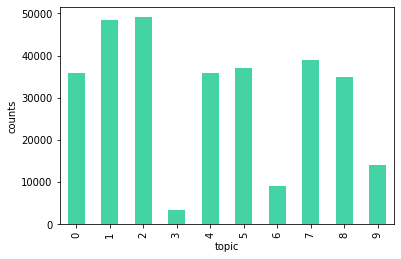

In [156]:
countTopDocs = df.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF() \
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess = countTopDocs.toPandas()

pdfLess.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

In [162]:
countTopDocs.show()

+---------+-----+
|nTopTopic|count|
+---------+-----+
|        0|35947|
|        1|48502|
|        2|49077|
|        3| 3521|
|        4|35920|
|        5|37180|
|        6| 9189|
|        7|38946|
|        8|34939|
|        9|14166|
+---------+-----+



### <font color = 'black'> Finding the Topic Of each Review and then plotting the distributin of topics by each rating.

In [175]:
countTopDocs = df.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF()

In [179]:
countTopDocs = countTopDocs.withColumn("index",monotonically_increasing_id())
close_businesses1 = close_businesses.join(countTopDocs, close_businesses.index == countTopDocs.index)

In [196]:
countTopDocs2 = close_businesses1.filter(close_businesses1['label'] == 1.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess2 = countTopDocs2.toPandas()

countTopDocs3 = close_businesses1.filter(close_businesses1['label'] == 2.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess3 = countTopDocs3.toPandas()


countTopDocs4 = close_businesses1.filter(close_businesses1['label'] == 3.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess4 = countTopDocs4.toPandas()


countTopDocs5 = close_businesses1.filter(close_businesses1['label'] == 4.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess5 = countTopDocs5.toPandas()


countTopDocs6 = close_businesses1.filter(close_businesses1['label'] == 5.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdfLess6 = countTopDocs6.toPandas()



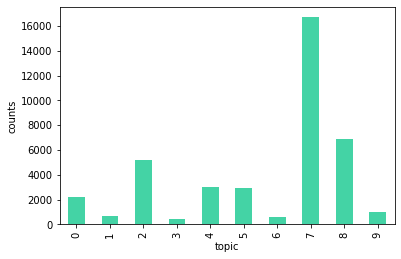

In [195]:

pdfLess2.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

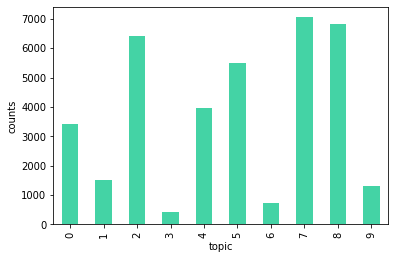

In [197]:

pdfLess3.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

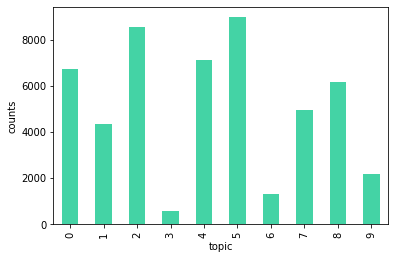

In [198]:

pdfLess4.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

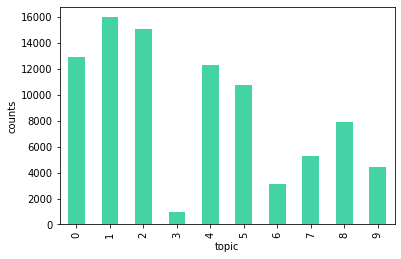

In [199]:

pdfLess5.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

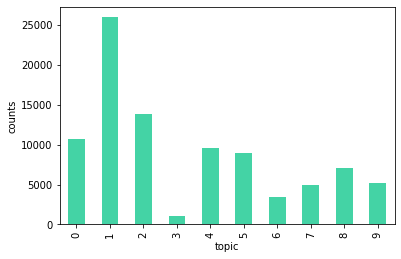

In [200]:

pdfLess6.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

# <font color = 'black'>  Open Businesses Topic Modelling

In [217]:
inner_join1 = open_businesses.withColumn("index",monotonically_increasing_id())

df_text1 = inner_join1.select("index","finished_clean_lemma")

cv1 = CountVectorizer(inputCol="finished_clean_lemma", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel1 = cv1.fit(df_text1)
result_cv1 = cvmodel1.transform(df_text1)

idf1 = IDF(inputCol="raw_features", outputCol="features")
idfModel1 = idf1.fit(result_cv1)
result_tfidf1 = idfModel1.transform(result_cv1) 

In [218]:
#split 80% train set and 20% test set
df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

num_topics=10
max_iterations= 30
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(result_tfidf1)

Training and testing documents:  245678 61709


# <font color = 'black'> List of topics with their word weightage. (Open-Businesses)

In [219]:
topics1 = ldaModel.describeTopics(maxTermsPerTopic=20)
vocabArray1 = cvmodel1.vocabulary
numTopics= 10

ListOfIndexToWords1 = udf(lambda wl: list([vocabArray1[w] for w in wl]))
FormatNumbers1 = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics1.select(ListOfIndexToWords1(topics1.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics1.select(FormatNumbers1(topics1.termWeights).alias('weights')).show(truncate=False, n=numTopics)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|[chicken, fry, pizza, sauce, good, order, rice, taste, steak, meat, burger, cook, like, pork, chip, get, flavor, cheese, taco, bean]                       |
|[die, und, raman, das, der, ist, ich, war, sehr, es, nicht, man, wir, mit, zu, auch, essen, crepe, ein, aber]                                              |
|[get, go, order, food, time, star, like, good, give, salad, one, dont, pizza, pay, money, bad, eat, wing, buffet, place]                                   |
|[buffet, sushi, seafood, good, crab, roll, indian, 

# <font color = 'black'> Topic - Modelling Analysis. (OPEN-BUSINESSES)

## <font color = 'black'> 1) Most Important Review in Each Topic

## <font color = 'black'> 2) Understanding the Distribution of Topics by Each Rating.    

In [220]:
df1 = ldaModel.transform(result_tfidf1) #defining the dataframe
numTopics_toShow=5 #
topWords = topics1.select(ListOfIndexToWords1(topics1.termIndices).alias('words')).take(numTopics_toShow)

nTopDoc = 1  # show single top document (1) or also second (2) ..

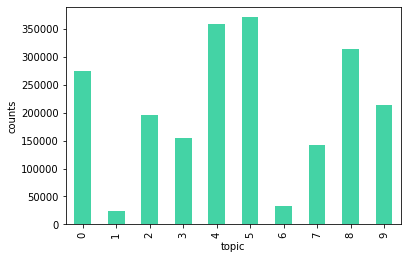

In [221]:
countTopDocs1 = df1.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF() \
                .groupBy("nTopTopic").count().sort("nTopTopic")

open_topic = countTopDocs1.toPandas()

open_topic.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

In [222]:
countTopDocs1 = df1.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF()



In [223]:
countTopDocs1 = countTopDocs1.withColumn("index",monotonically_increasing_id())
open_businesses = open_businesses.withColumn("index",monotonically_increasing_id())
open_businesses1 = open_businesses.join(countTopDocs1, open_businesses.index == countTopDocs1.index)

In [224]:
countTop = open_businesses1.filter(open_businesses1['label'] == 1.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf = countTop.toPandas()

countTop2 = open_businesses1.filter(open_businesses1['label'] == 2.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf2 = countTop2.toPandas()


countTop3 = open_businesses1.filter(open_businesses1['label'] == 3.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf3 = countTop3.toPandas()


countTop4 = open_businesses1.filter(open_businesses1['label'] == 4.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf4 = countTop4.toPandas()


countTop5 = open_businesses1.filter(open_businesses1['label'] == 5.00)\
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf5 = countTop5.toPandas()



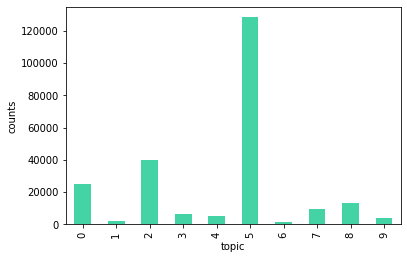

In [225]:

pdf.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

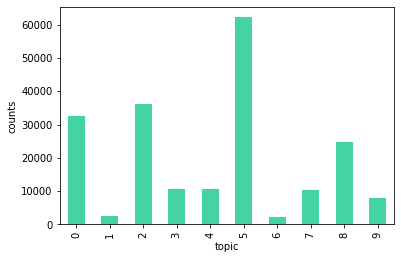

In [226]:

pdf2.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

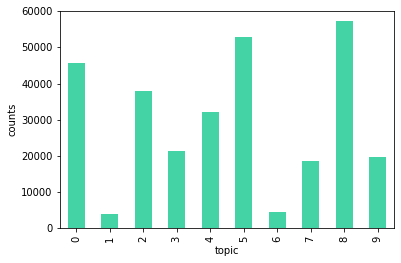

In [227]:

pdf3.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

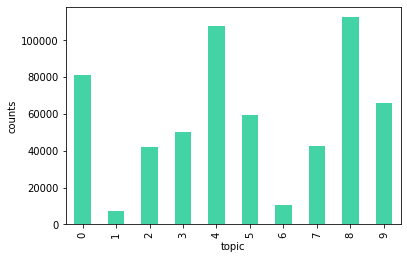

In [228]:

pdf4.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

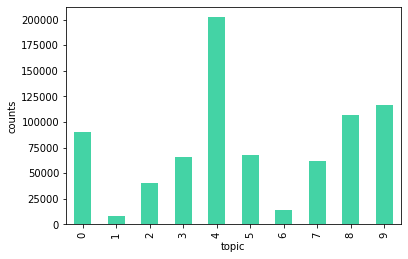

In [229]:

pdf5.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

# <font color ='black'> Conclusion

## <font color ='black'> The most important Reasons that look to leading to the Closure of Restaurants in USA are 

## <font color ='black'> poor customer service and poor mexican food. Open Businesses tend to have more favourable topics